In [1]:
import numpy as np
import pandas as pd

from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import load_wine

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.utils import shuffle

In [2]:
data = load_wine()
frame = pd.DataFrame(data.data, columns=data.feature_names)
frame['target'] = data.target
features = list(data.feature_names)
frame = shuffle(frame, random_state=0)
frame.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
54,13.74,1.67,2.25,16.4,118.0,2.60,2.90,0.21,1.62,5.85,0.92,3.20,1060.0,0
151,12.79,2.67,2.48,22.0,112.0,1.48,1.36,0.24,1.26,10.80,0.48,1.47,480.0,2
63,12.37,1.13,2.16,19.0,87.0,3.50,3.10,0.19,1.87,4.45,1.22,2.87,420.0,1
55,13.56,1.73,2.46,20.5,116.0,2.96,2.78,0.20,2.45,6.25,0.98,3.03,1120.0,0
123,13.05,5.80,2.13,21.5,86.0,2.62,2.65,0.30,2.01,2.60,0.73,3.10,380.0,1


In [3]:
features = features[len(features) // 2:]

split = len(frame) // 2
train = frame[:split]
test = frame[split:]

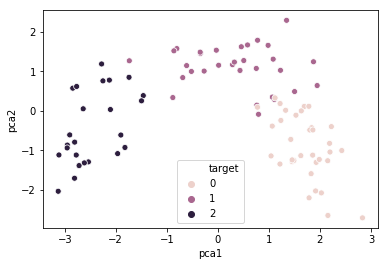

In [4]:
import warnings
warnings.filterwarnings('ignore')

scaler = StandardScaler().fit(train[features])
scaled_train = scaler.transform(train[features])
scaled_test = scaler.transform(test[features])

pca = KernelPCA(2, kernel='linear', random_state=0).fit(scaled_train)

train['pca1'] = pca.transform(scaled_train).T[0]
train['pca2'] = pca.transform(scaled_train).T[1]

test['pca1'] = pca.transform(scaled_test).T[0]
test['pca2'] = pca.transform(scaled_test).T[1]

sns.scatterplot(x="pca1", y="pca2", hue="target", data=test);

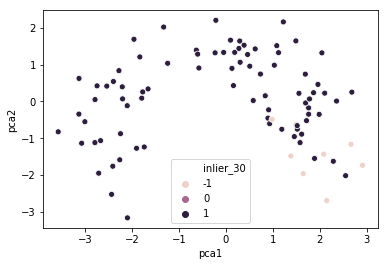

In [5]:
inliers = []
for depth in range(5, 35, 5):
  isolator = LocalOutlierFactor(n_neighbors=depth, novelty=True).fit(train[features])

  train['inlier_' + str(depth)] = isolator.predict(train[features])
  test['inlier_' + str(depth)] = isolator.predict(test[features])
  
  inliers.append('inlier_' + str(depth))

sns.scatterplot(x="pca1", y="pca2", hue=inliers[-1], data=train);
plt.savefig('/home/andrey/8.svg', format='SVG')

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression().fit(train[features], train.target)
print("%.4f" % classifier.score(test[features], test.target))

classifier = GradientBoostingClassifier().fit(train[features], train.target)
print("%.4f" % classifier.score(test[features], test.target))

classifier = LogisticRegression().fit(train[features + inliers], train.target)
print("%.4f" % classifier.score(test[features + inliers], test.target))

classifier = LogisticRegression().fit(train[features + inliers + ['pca1', 'pca2']], train.target)
print("%.4f" % classifier.score(test[features + inliers + ['pca1', 'pca2']], test.target))

classifier = LogisticRegression().fit(train[features + ['pca1', 'pca2']], train.target)
print("%.4f" % classifier.score(test[features + ['pca1', 'pca2']], test.target))

0.9213
0.9326
0.9438
0.9663
0.9663
